In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
zip_lon_lat = pd.read_csv('county.csv')
zip_lon_lat.head()

,Unnamed: 0,zip_code,latitude,longitude,county
0,0,7001,40.582316,-74.271506,16
1,1,7002,40.662338,-74.110275,2
2,2,7003,40.809128,-74.187155,2
3,3,7004,40.882508,-74.304593,19
4,4,7005,40.932771,-74.417304,19


In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,Unnamed: 0,latitude,longitude,county
7749,5.0,4.0,0.91,8848.0,0.0,485000.0,2017,568,40.594266,-75.096659,11
7750,4.0,3.0,2.17,8825.0,0.0,510000.0,2016,553,40.514169,-75.027112,11
7751,3.0,2.0,0.12,7012.0,0.0,499000.0,2021,10,40.848398,-74.160266,2
7752,3.0,3.0,0.13,7012.0,0.0,530000.0,2022,10,40.848398,-74.160266,2
7753,4.0,3.0,0.11,7640.0,0.0,720000.0,2016,171,40.991681,-73.980202,15


In [7]:
features = ["bed","bath","county","house_size","prev_sold_year","acre_lot"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
#"bed","bath","acre_lot","zip_code","house_size","prev_sold_year"
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[]}
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [10]:
cv_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
    svr = SVR(kernel=k)
    scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]

In [11]:
params = {
    'C': [100],
    'gamma': [.01],
    'kernel': [optimal_kernel]
}

svr_gscv = GridSearchCV(SVR(), params, refit=True, verbose=2, cv=5).fit(X, y)
print(f"Best parameters found: {svr_gscv.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=  18.3s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=  24.1s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=  20.2s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   9.7s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=  14.5s
Best parameters found: {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}


In [12]:
svr = SVR(**svr_gscv.best_params_)
svr_model = svr.fit(X_train,y_train)
svr_predict = svr_model.predict(X_test)
svr_mse = mean_squared_error(y_test,svr_predict)

print_more_stuff("Support Vector Machine", y_test, svr_predict)

Support Vector Machine EVS = 0.326592623
Support Vector Machine MSE = 129,316,029,710.477066
Support Vector Machine MAE = 205,155.158675
Support Vector Machine R2 = 0.269762


In [13]:
svr_rfe = RFE(SVR(**svr_gscv.best_params_), n_features_to_select=num_features_to_select, step=1)
svr_rfe.fit(X, y)
svr_rfe_selected_features = svr_rfe.get_support()
print('The selected features are:', list(X.columns[svr_rfe_selected_features]))

The selected features are: ['bed', 'bath', 'county', 'prev_sold_year', 'acre_lot']


In [14]:
X_rfe = merged_df[list(X.columns[svr_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [15]:
svr_rfe = SVR(**svr_gscv.best_params_)
svr_rfe_model = svr_rfe.fit(X_rfe_train,y_rfe_train)
svr_rfe_predict = svr_rfe_model.predict(X_rfe_test)
print_more_stuff("Recursive Feature Elimination", y_test, svr_rfe_predict)

Recursive Feature Elimination EVS = 0.327104819
Recursive Feature Elimination MSE = 129,278,012,593.585083
Recursive Feature Elimination MAE = 205,093.896807
Recursive Feature Elimination R2 = 0.269977


In [16]:
svr_sfs = SequentialFeatureSelector(SVR(**svr_gscv.best_params_), n_features_to_select=num_features_to_select)
svr_sfs.fit(X, y)
svr_sfs_selected_features = svr_sfs.get_support()
print('The selected features are:', list(X.columns[svr_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'county', 'house_size', 'prev_sold_year']


In [17]:
X_sfs = merged_df[list(X.columns[svr_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [18]:
svr_sfs = SVR(**svr_gscv.best_params_)
svr_sfs_model = svr_sfs.fit(X_sfs_train,y_sfs_train)
svr_sfs_predict = svr_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_test, svr_sfs_predict)

Sequential Feature Selector EVS = 0.323140796
Sequential Feature Selector MSE = 129,903,096,165.637512
Sequential Feature Selector MAE = 205,702.497061
Sequential Feature Selector R2 = 0.266447


In [19]:
svr_predict_df = pd.DataFrame(svr_predict).reset_index()
svr_predict_df.rename(columns={0: "prediction"},inplace=True)

svr_sfs_predict_df = pd.DataFrame(svr_sfs_predict).reset_index()
svr_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

svr_rfe_predict_df = pd.DataFrame(svr_rfe_predict).reset_index()
svr_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()



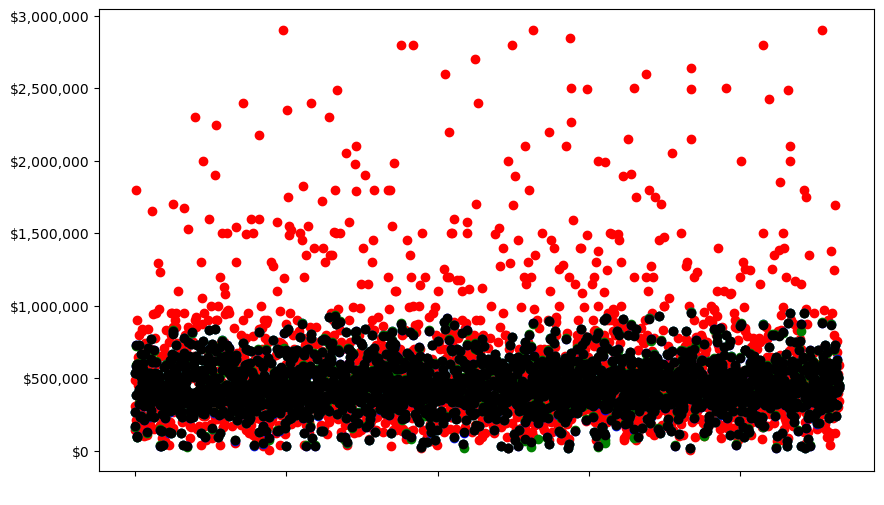

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(svr_rfe_predict_df.index,svr_rfe_predict_df["prediction"], color="blue")
plt.scatter(svr_sfs_predict_df.index,svr_sfs_predict_df["prediction"], color="green")
plt.scatter(svr_predict_df.index,svr_predict_df["prediction"], color="black")
plt.show()

In [21]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score
model,,,,
Support Vector Machine,0.326592623,"205,155.158675","129,316,029,710.477066",0.269762
Recursive Feature Elimination,0.327104819,"205,093.896807","129,278,012,593.585083",0.269977
Sequential Feature Selector,0.323140796,"205,702.497061","129,903,096,165.637512",0.266447
